In [ ]:

#1 DEFINE CONNECTIVITY AND INPUTS

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import special
from scipy.stats import norm
from scipy.stats import pearsonr
from scipy import signal
from scipy.fft import fftshift

import networkx as nx
import numpy as np
import pandas as pd

T = 50000
dt=0.1
N=100
d=-1
beta=50
D =0.000

B=-0.05 #-0.05
rho =0.05 #connectoin probability
f=0.8#proportion of e vs i cells/cortical
sigma_e_2 = 0.005
sigma_i_2 = 0.005
#AXEL: INCREASE MU_E TO INCREASE INSTABILITY AND FLUCTUATIONS AMPLITUDE
mu_e= 0.08 #0.8 so that the variance scales like 1/N
mu_i= -f/(1-f)*mu_e



#arrays for network dynamics 
u = np.zeros((N,T))
time=np.arange(0,T,1)
mean_u = np.zeros(T)
#environmental perturbations
perturbations = np.zeros(T)
filtered_noise_1 = np.zeros(T)
filtered_noise_2 = np.zeros(T)
filtered_noise_3 = np.zeros(T)
Noise=0.05 #0.2
for t in range(len(time)-1):
  perturbations[t+1] = perturbations[t]+dt*(-perturbations[t]+filtered_noise_1[t])
  filtered_noise_1[t+1]= filtered_noise_1[t]+dt*0.1*(-1*filtered_noise_1[t]+filtered_noise_2[t])
  filtered_noise_2[t+1]= filtered_noise_2[t]+dt*0.1*(-1*filtered_noise_2[t]+filtered_noise_3[t])
  filtered_noise_3[t+1]= filtered_noise_3[t]+dt*(-1*filtered_noise_3[t])+np.sqrt(2*Noise*dt)*np.random.normal(0,1)
 


W = np.zeros((N,N))
M_e=np.random.normal(mu_e, np.sqrt(sigma_e_2), size=(N,N))
M_i=np.random.normal(mu_i, np.sqrt(sigma_i_2), size=(N,N))

List = np.zeros(N);
for i in range(N):
  for j in range(N):
    P_connectivity = np.random.rand()
    if (P_connectivity<rho):
      if (j<int(f*N)):
        List[j] = M_e[i][j];
      else:
        List[j] = M_i[i][j];
    else:
      List[j] = 0;
  np.random.shuffle(List)  
  for j in range(N):
    if i==j:
      W[i][j]=0
    else:
      W[i][j]=List[j]
row_sum=np.zeros(N)
for i in range(N):
  row_sum[i] =(np.sum(W[i][:]))
  number_of_nonzero_entries=0
  for j in range(N):
    if W[i][j]!=0:
      number_of_nonzero_entries = number_of_nonzero_entries+1
  for j in range(N):
    if W[i][j]!=0:  
      W[i][j]=W[i][j]-row_sum[i]/number_of_nonzero_entries


   
#variance connectivity matrix - scales like 1/N by construction
sigma_2 = rho*(f*sigma_e_2+(1-f)*sigma_i_2+f/(1-f)*mu_e**2)
print(W)
print(np.var(W),sigma_2)
print(np.mean(W))
# for i in range(N):
#   print(np.sum(W[i][:]))




# plt.plot(time,perturbations, color='red',  linewidth=4, alpha=0.5)
# plt.ylim(-1.5, 1.5) 
# plt.show()


[[ 0.          0.          0.         ...  0.         -0.00746931
  -0.03379576]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [-0.03936268  0.          0.         ...  0.          0.
   0.15431978]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
0.0012903489886996104 0.0015300000000000005
0.0


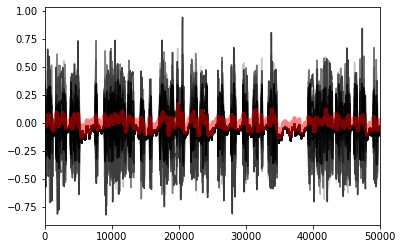

In [ ]:
#2 NETWORK DYNAMICS

sigma_h=0
#resonse function of neurons
def F(u,h):
  output =0.5*(1+special.erf(beta*(u+h)))#np.tanh(beta*u)# 1/(1+np.exp(-beta*u))
  return output


threshold = np.zeros(N)
#Euler integration
for i in range(N):
  u[i][0] = 0.05*np.random.normal(0,1)
  threshold[i] = np.sqrt(sigma_h)*np.random.normal(0,1)
for t in range(T-1):
  mean_u[t]=0
  for i in range(N):
    sum=0
    for j in range(N):
      sum=sum+W[i][j]*F(u[j][t],threshold[j])
    u[i][t+1] = u[i][t] +dt*(d*u[i][t]+sum+perturbations[t]+B)+np.sqrt(2*D*dt)*np.random.normal(0,1)
    mean_u[t] = mean_u[t]+1/N*(u[i][t]-perturbations[t])


#computing fixed point from numeris asymptotically - only works id network stable!
fixed_point = np.zeros(N)

for i in range(N):
  fixed_point[i]=u[i][T-1]
sigma_fixed_points_2 = np.var(fixed_point)

#plotting network dynamics

colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greys(np.linspace(0, 1, N))))
for i in range(N):
    plt.plot(time,u[i][:])
plt.plot(time,perturbations, color='red',  linewidth=4, alpha=0.5)
# plt.ylim(-0.5, 1.5) 
plt.xlim(0, T) 
# plt.xlim(T/2-1, T/2+30) 
plt.show()

#plot temporal deviations
# mu_u=np.zeros(N)
# deviation = np.zeros(T)
# mu_perturbation = np.mean(perturbations[:])
# for i in range(N):
#   mu_u[i]=np.mean(u[i][:])-mu_perturbation
# for t in range(T):
#   for i in range(N):
#     deviation[t] = deviation[t]+1/N*np.abs(u[i][t]-mu_u[i]-perturbations[t])
# plt.plot(time,deviation, color='red',  linewidth=4, alpha=0.5)
# plt.ylim(0, 0.20) 
# plt.show()


#plot spectrogram
# x = u[23][:]
# f, t, Sxx = signal.spectrogram(x, 1e3)
# plt.pcolormesh(t, f, Sxx, shading='gouraud')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.ylim(0, 200) 
# plt.show()

# colormap = plt.cm.gist_ncar
# plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greens(np.linspace(0, 1, N))))
# for i in range(N):
#     plt.plot(time,v[i][:])
# plt.ylim(-1.5, 1.5) 
# plt.show()

#correlation matrix
# Corr = np.zeros((N,N))

# for i in range(N):
#   for j in range(N):
#     data_1 = np.zeros(T)
#     data_2 = np.zeros(T)
#     for t in range(T):
#       data_1[t] = v[i][t] 
#       data_2[t] = v[j][t]
#     Corr[i][j] = pearsonr(data_1,data_2)[0]
# plt.imshow(Corr, cmap='hot', interpolation='nearest')
# plt.show()
# plt.imshow(W, cmap='seismic')
# plt.show()


#plotting spike trains
# neuron =[]
# spiketime = []
# t_window=50
# for t in range(len(time)-t_window):
#   for i in range(N):
#     for s in range(t_window):
#       if (Spikes[i][t-int(t_window/2)+s]>0.1):
#         firing_rate[i][t+int(t_window/2)]=firing_rate[i][t+int(t_window/2)]+1/t_window
# for t in range(len(time)-1):
#   for i in range(N):
#     if (Spikes[i][t]>0.1):
#       neuron.append(i)
#       spiketime.append(t*dt)
      
  
# plt.plot(spiketime,neuron,'|');
# plt.show()



#colormap = plt.cm.gist_ncar
#plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greens(np.linspace(0, 1, N))))
# for t in range(len(time)-1):
#   for i in range(N):
#     mean_firing_rate[t] = mean_firing_rate[t] +1/N*firing_rate[i][t]
# plt.plot(time,mean_firing_rate, color="black")
# for i in range(N):
#     plt.plot(time,firing_rate[i][:], alpha=0.15)
# plt.show()

# Spectral_radius_in_time = np.zeros(len(time))
# Spectral_radius_theo_in_time =  np.zeros(len(time))
# for t in range(len(time)):
#   J_o = np.zeros((N,N))
#   for i in range(N):
#     for j in range(N):
#       J_o[i][j] = W[i][j]*beta/np.sqrt(np.pi)*np.exp(-beta**2*(perturbations[t])**2)
#   Var_J_o = np.var(J_o)
#   Spectral_radius_in_time[t] = np.sqrt(N*Var_J_o)
#   Spectral_radius_theo_in_time[t] = np.sqrt(N*sigma_2*beta**2/(np.pi*np.sqrt(4*0*beta**2+1))*(np.exp(-beta**2*(perturbations[t])**2))**2)
# plt.rcParams.update({'font.size': 22})
# for pos in ['right', 'top', 'bottom', 'left']:
#    plt.gca().spines[pos].set_visible(False)
# plt.plot(time,Spectral_radius_in_time,color="blue",linewidth=4)
# plt.plot(time,Spectral_radius_theo_in_time,color="blue",linewidth=2,alpha=0.4)
# plt.plot(time,np.ones(len(time)),color='k',linestyle="--")
# plt.show()






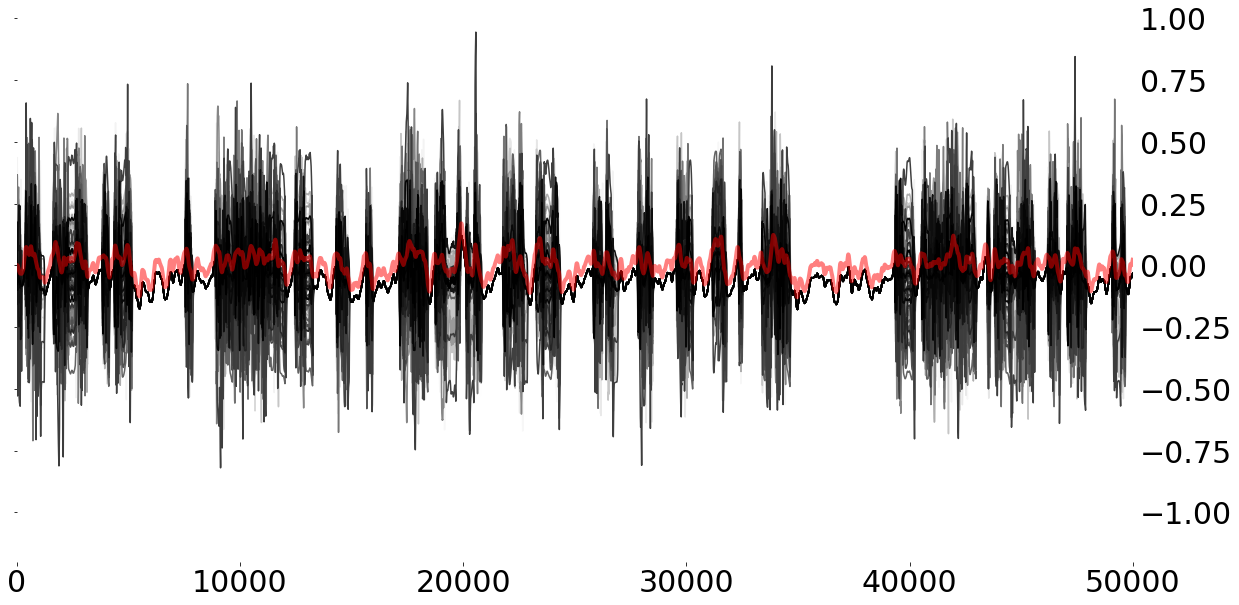

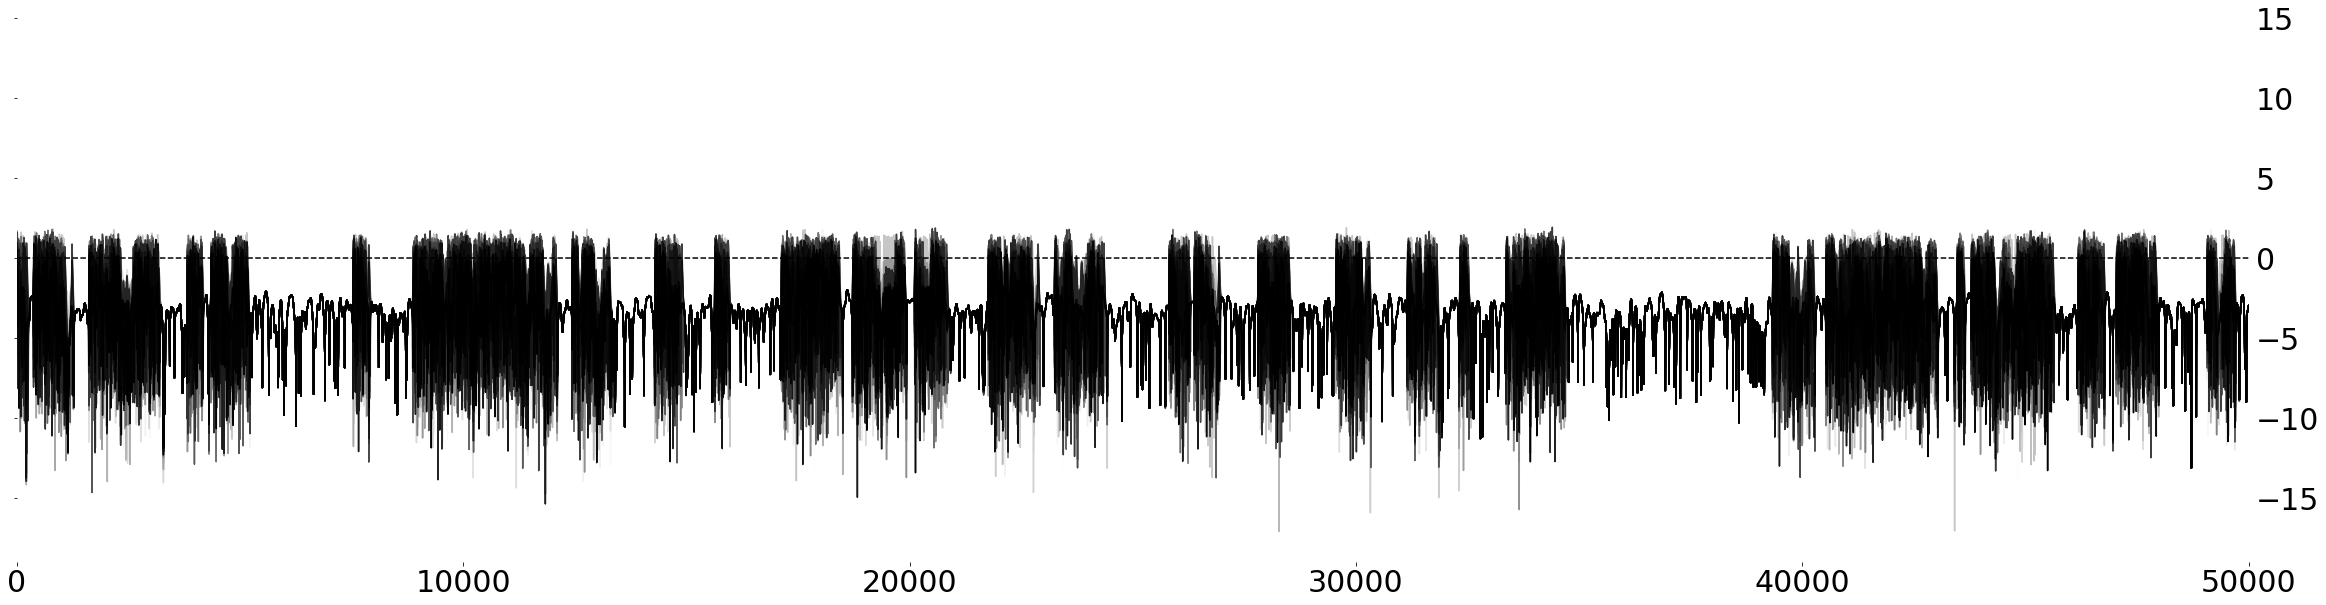

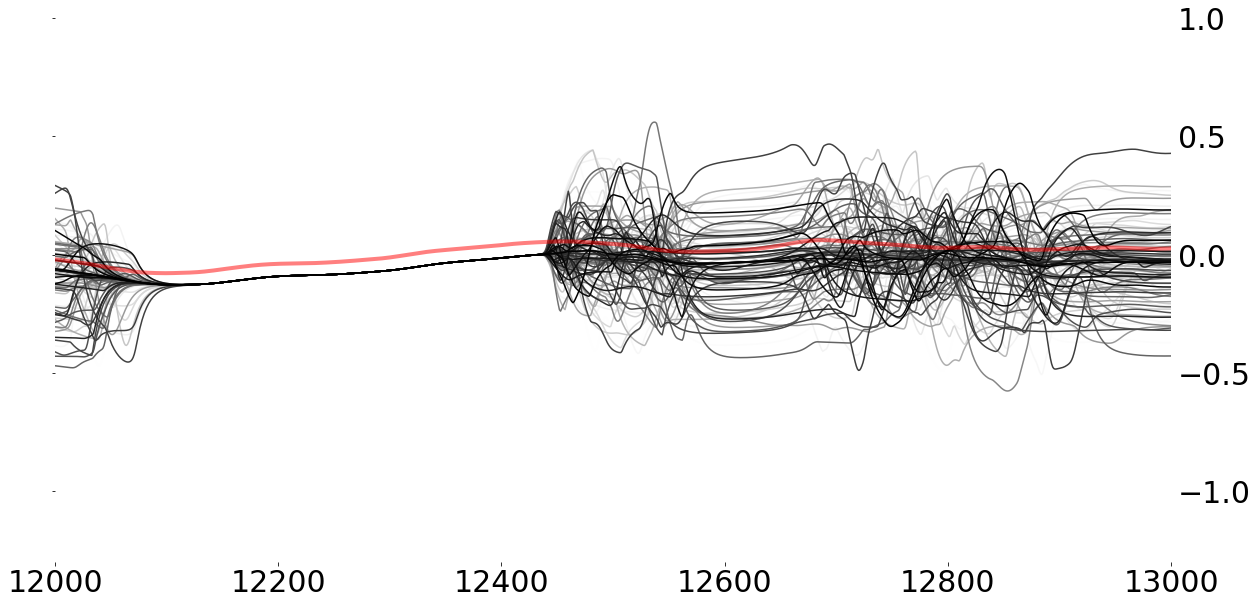

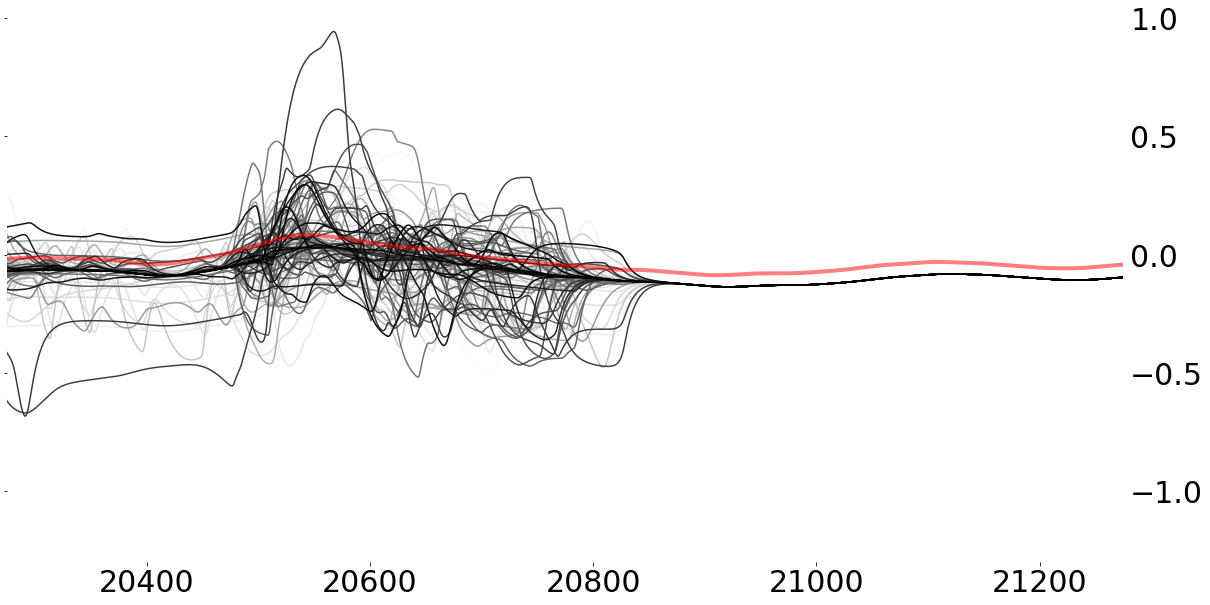

1.395865875443259e-32
0.07650000000000003


In [ ]:
# 5 Visualization in time and Lyapunov exponemts

plt.figure(figsize=(20,10))
colormap = plt.cm.gist_ncar
plt.rcParams.update({'font.size': 30})
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greys(np.linspace(0, 1, N))))
for i in range(N):
    plt.plot(time,u[i][:])
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.plot(time,perturbations, color='red',  linewidth=4, alpha=0.5)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
# x_ticks = np.arange(13000,15000,1000)  # Set label locations.
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.ylim(-1.2, 1) 
plt.xlim(0, T) 
plt.show()

colormap = plt.cm.gist_ncar
plt.figure(figsize=(40,10))
plt.rcParams.update({'font.size': 30})
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greys(np.linspace(0, 1, N))))
t_prime=time[:int(T)-1]
for i in range(N):
  plt.plot(t_prime,np.log(np.abs(np.diff((u[i][0:int(T)]))/0.01)))
plt.plot(t_prime,np.zeros(int(T)-1),"--", color='black')
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.ylim(-19, 15) 
plt.xlim(0, T) 
final = np.zeros(N)
for i in range(N):
  final[i] = u[i][T-1]

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 30})
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greys(np.linspace(0, 1, N))))
for i in range(N):
    plt.plot(time,u[i][:])
plt.plot(time,perturbations, color='red',  linewidth=4, alpha=0.5)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
x_ticks = np.arange(400,650,50)  # Set label locations.
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.ylim(-1.3, 1) 
plt.xlim(12000,13000) 
plt.show()

plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 30})
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greys(np.linspace(0, 1, N))))
for i in range(N):
    plt.plot(time,u[i][:])
plt.plot(time,perturbations, color='red',  linewidth=4, alpha=0.5)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
x_ticks = np.arange(400,650,50)  # Set label locations.
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.ylim(-1.3, 1) 
plt.xlim(20275,21275) 

#plt.xlim(15500,16500) 
plt.show()



print(np.var(final))
print(N*rho*(f*sigma_e_2+(1-f)*sigma_i_2+f/(1-f)*mu_e**2)/2)


In [ ]:
from google.colab import files
from numpy import savetxt
U = np.zeros((T,2))
for t in range(T):
  U[t][0] = t
  U[t][1] = mean_u[t]

# U = [[1,3],[4,6]]
savetxt('data_homo.txt', U, delimiter='  ')
# from google.colab import files
# files.download('U.txt') 

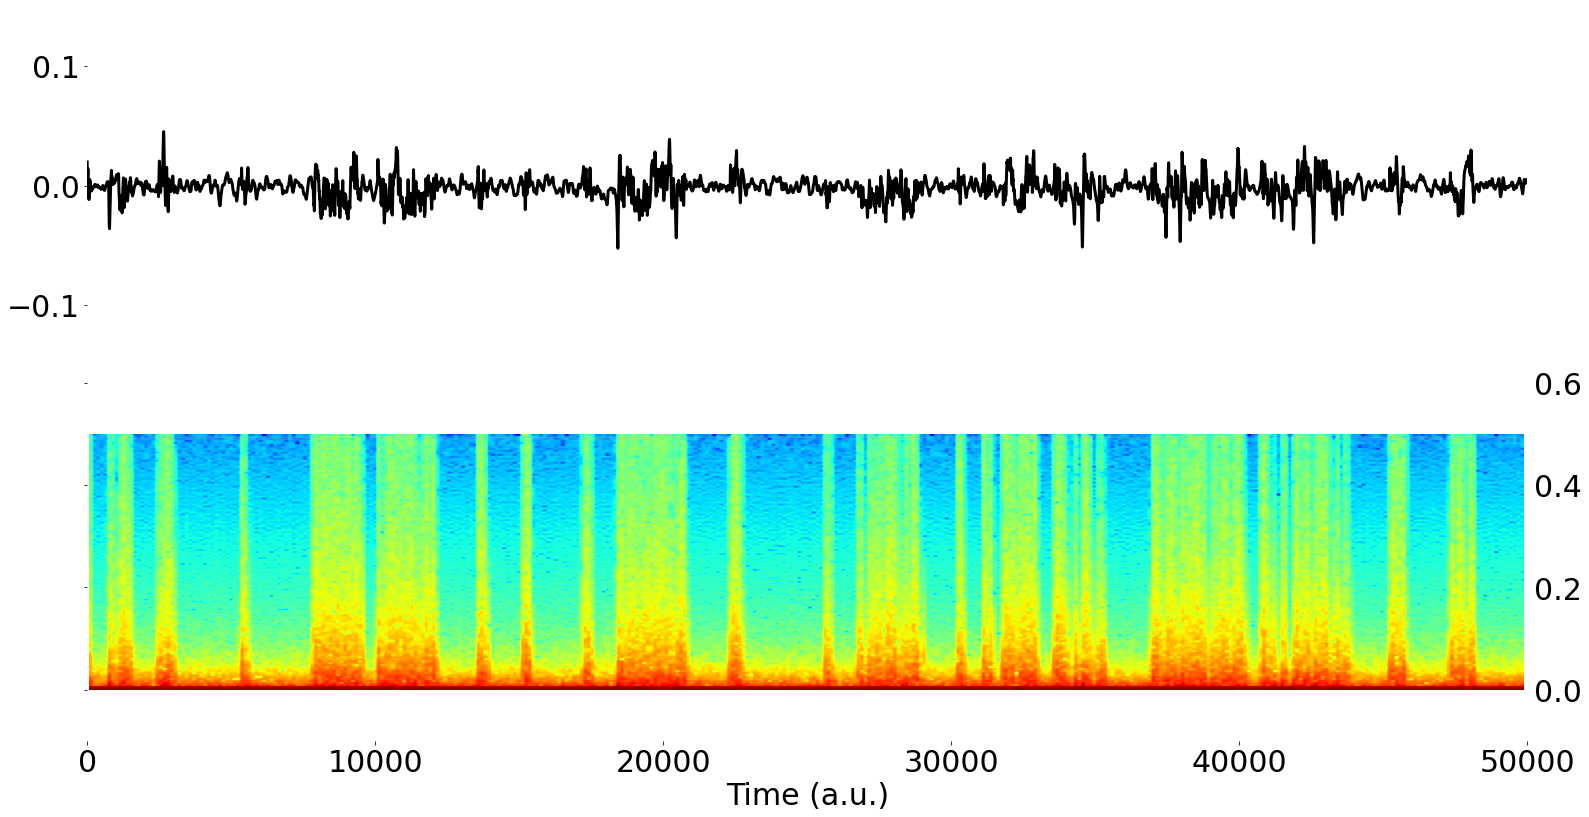

In [ ]:
plt.figure(figsize=(25,17))
plt.rcParams.update({'font.size': 30})
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.7,
                    wspace=4,
                    hspace=0.05)
plt.subplot(211)
# colormap = plt.cm.gist_ncar

plt.tick_params(axis='y', which='both', labelleft=True, labelright=False )
# plt.plot(time, mean_u-B, color="black", linewidth=3)
colormap = plt.cm.gist_ncar
plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.Greys(np.linspace(0, 1, N))))
# for i in range(N):
#     plt.plot(time,u[i][:])
# plt.plot(time, 0.5*perturbations, color = "Red", linewidth=3, alpha=0.7)
plt.plot(time, mean_u-B, color = "Black", linewidth=3)
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
plt.ylim(-0.15, 0.15) 
plt.xlim(10, T-10) 
plt.xticks([])
plt.subplot(212)

signalData = mean_u
# cmap = plt.get_cmap('inferno')
# cmap.set_under(color='k', alpha=None)
plt.specgram(signalData,Fs=1,cmap='jet')
for pos in ['right', 'top', 'bottom', 'left']:
   plt.gca().spines[pos].set_visible(False)
plt.tick_params(axis='y', which='both', labelleft=False, labelright=True)
plt.xlabel('Time (a.u.)')
plt.xlim(0, T) 
plt.ylim(-0.1, 0.6) 
plt.show()